In [1]:
import gym
import torch as th
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import os, sys
from collections import deque

from stable_baselines3 import PPO, SAC, HerReplayBuffer
# from sb3_contrib import RAD_SAC, RAD_PPO

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, EveryNTimesteps, BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    SubprocVecEnv,
    VecTransposeImage,
    VecFrameStack,
)

import tactile_gym.rl_envs
from tactile_gym.sb3_helpers.custom.custom_torch_layers import CustomCombinedExtractor
from tactile_gym.sb3_helpers.params import import_parameters
from tactile_gym.sb3_helpers.rl_utils import make_training_envs, make_eval_env
from tactile_gym.sb3_helpers.eval_agent_utils import final_evaluation
from tactile_gym.sb3_helpers.rl_plot_utils import plot_train_and_eval
from tactile_gym.utils.general_utils import (
    save_json_obj,
    print_sorted_dict,
    convert_json,
    check_dir,
)

from tactile_gym.sb3_helpers.custom.custom_callbacks import (
    FullPlottingCallback,
    ProgressBarManager,)

# produce a display to render image
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

pybullet build time: Mar  8 2021 17:26:24


In [2]:
from stable_baselines3.common.noise import NormalActionNoise, VectorizedActionNoise
action_noise = NormalActionNoise(np.zeros((10,2)), np.ones((10,2))*0.1)
print(action_noise())

[[0.037539 -0.188236]
 [0.022050 -0.071573]
 [0.162678 0.100856]
 [0.029640 0.259405]
 [0.106900 -0.018980]
 [-0.164672 -0.123981]
 [-0.058325 -0.118775]
 [0.085345 -0.218108]
 [-0.111749 0.167116]
 [0.036803 0.051918]]


In [3]:
# choose which RL algo to use
algo_name = 'sac'
# algo_name = 'sac_her'
# algo_name = 'rad_ppo'
# algo_name = 'sac'
# algo_name = 'rad_sac'

# env_name = "edge_follow-v0"
# env_name = 'surface_follow-v0'
# env_name = 'object_roll-v0'
env_name = 'object_push-v0'
# env_name = 'object_balance-v0'

# import paramters
rl_params, algo_params, augmentations = import_parameters(env_name, algo_name)
rl_params["total_timesteps"] = 2000000
rl_params["eval_freq"] = 10000
rl_params["n_envs"] = 1
rl_params["max_ep_len"] = 1000
# her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future', online_sampling=True, max_episode_length=1000)
# algo_params["replay_buffer_kwargs"] = her_kwargs

# Define environment parameters
rl_params["env_modes"]["observation_mode"] = "goal_aware_tactile_pose_relative"
rl_params["env_modes"][ 'control_mode'] = 'TCP_position_control'
rl_params["env_modes"][ 'terminate_early']  = True
rl_params["env_modes"]['terminate_terminate_early'] = False
rl_params["env_modes"]['terminate_using_center'] = False
rl_params["env_modes"]['reward_using_center'] = False
rl_params["env_modes"][ 'use_contact'] = True
rl_params["env_modes"][ 'traj_type'] = 'point'
rl_params["env_modes"][ 'task'] = "goal_pos"
rl_params["env_modes"][ 'reward_mode'] = "dense"
rl_params["env_modes"]['planar_states'] = True

rl_params["env_modes"]['additional_reward_settings'] = 'john_guide_off_normal'
rl_params["env_modes"]['importance_obj_goal_pos'] = 1.0
rl_params["env_modes"]['importance_obj_goal_orn'] = 1.0
rl_params["env_modes"]['importance_tip_obj_orn'] = 1.0    
rl_params["env_modes"]['terminated_early_penalty'] = -100
rl_params["env_modes"]['reached_goal_reward'] = 100
rl_params["env_modes"]['terminated_early_penalty'] = 0
rl_params["env_modes"]['reached_goal_reward'] = 0

rl_params["env_modes"]['max_no_contact_steps'] = 1000
rl_params["env_modes"]['max_tcp_to_obj_orn'] = 180/180 * np.pi

# set limits and goals
TCP_lims = np.zeros(shape=(6, 2))
TCP_lims[0, 0], TCP_lims[0, 1] = -0.1, 0.3  # x lims
TCP_lims[1, 0], TCP_lims[1, 1] = -0.3, 0.3  # y lims
TCP_lims[2, 0], TCP_lims[2, 1] = -0.0, 0.0  # z lims
TCP_lims[3, 0], TCP_lims[3, 1] = -0.0, 0.0  # roll lims
TCP_lims[4, 0], TCP_lims[4, 1] = -0.0, 0.0  # pitch lims
TCP_lims[5, 0], TCP_lims[5, 1] = -180 * np.pi / 180, 180 * np.pi / 180  # yaw lims

# goal parameter
# goal_edges = [(0, -1), (0, 1), (1, 0)] # Top bottom and stright
goal_edges = [(1, 0)]
goal_x_max = np.float64(TCP_lims[0, 1] * 0.9).item()
goal_x_min = 0.0 # np.float64(TCP_lims[0, 0] * 0.6).item()
goal_y_max = np.float64(TCP_lims[1, 1] * 0.6).item()
goal_y_min = np.float64(TCP_lims[1, 0] * 0.6).item()
goal_ranges = [goal_x_min, goal_x_max, goal_y_min, goal_y_max]

rl_params["env_modes"]['tcp_lims'] = TCP_lims.tolist()
rl_params["env_modes"]['goal_edges'] = goal_edges
rl_params["env_modes"]['goal_ranges'] = goal_ranges

In [4]:
# env = gym.make(env_name,
#     max_steps=rl_params["max_ep_len"],
#     image_size=rl_params["image_size"],
#     env_modes=rl_params["env_modes"],
#     obs_stacked_len=4,
#     show_gui=False,
#     show_tactile=False,
# )

argv[0]=
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 495.29.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 495.29.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [5]:
# print(env.observation_space)

# env.reset()
# for i in range(4):
#     obs, _, done, _ = env.step(env.action_space.sample())
#     print(obs)
#     if done:
#         break

# print(eval_env.dense_reward())
# print(eval_env.compute_dense_reward())

{'oracle': array([[0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000],
       [0.000869, 0.000002, 0.000003, 1.000000, -0.270000, 0.038704,
        0.071129, 0.997467],
       [0.001125, -0.000023, -0.001252, 0.999999, -0.269344, 0.039192,
        0.069926, 0.997552]])}
{'oracle': array([[0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000],
       [0.000869, 0.000002, 0.000003, 1.000000, -0.270000, 0.038704,
        0.071129, 0.997467],
       [0.001125, -0.000023, -0.001252, 0.999999, -0.269344, 0.039192,
        0.069926, 0.997552],
       [0.001281, -0.000028, -0.004663, 0.999989, -0.268752, 0.038982,
        0.071764, 0.997422]])}
{'oracle': array([[0.000869, 0.000002, 0.000003, 1.000000, -0.270000, 0.038704,
        0.071129, 0.997467],
       [0.001125, -0.000023, -0.001252, 0.999999, -0.269344, 0.039192,
       

In [8]:
# class stacked_states:
#     def __init__(self, stacked_num, states_num):
#         self.stacked_num = stacked_num
#         self.states_num = states_num
#         self.values = np.zeros((stacked_num, states_num))

#     def append(self, state):
#         self.values = np.append(self.values, state, axis = 0)

# obs = stacked_states(4, 8)
# obs.append(np.random.rand(1, 8))
# print(obs.values)

In [ ]:
# env.reset()
# print(env.dense_reward())

# if env.observation_mode == "tactile_pose_goal_excluded_goal_based":
#     obs = env.get_tactile_pose_obs_goal_exluded()
#     goals = env.get_tactile_pose_goal_exluded_goal_obs()

# elif env.observation_mode == "tactile_pose_goal_based":
#     obs = env.get_tactile_pose_obs()
#     goals = env.get_tactile_pose_goal_obs()

# elif env.observation_mode == "tactile_pose_updated_goal_based":
#     obs = env.get_tactile_pose_updated_obs()
#     goals = env.get_tactile_pose_updated_goal_obs()

# obs = np.expand_dims(obs ,0)
# goals = np.expand_dims(goals ,0)
# print(env.compute_reward(obs, goals, {})[0])

# obs = env.get_observation()
# print(env.compute_reward(np.expand_dims(obs['observation'], 0), np.expand_dims(obs['desired_goal'], 0), {})[0])
# print(env.compute_dense_reward())

# print(env.envs[0].dense_reward())
# print(env.envs[0].dense_goal_reward())
# print(abs(env.envs[0].get_tactile_pose_obs_goal_exluded() - env.envs[0].get_goal_obs()))
# print(abs(env.envs[0].get_observation()["observation"] - env.envs[0].get_goal_obs()))
# print(env.envs[0].get_tactile_pose_obs())
# print(env.envs[0].reward_weights)

-1.2880933130772658
-1.288093279495268
-1.288093279495268
-1.288093279495268


In [4]:
# create save dir
save_dir = os.path.join(
    "saved_models/", rl_params["env_name"], algo_name, "s{}_{}".format(rl_params["seed"], rl_params["env_modes"]["observation_mode"])
)
check_dir(save_dir)
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

saved_models/object_push-v0/sac/s1_goal_aware_tactile_pose_relative


In [ ]:
# # save params
# save_json_obj(convert_json(rl_params), os.path.join(save_dir, "rl_params"))
# save_json_obj(convert_json(algo_params), os.path.join(save_dir, "algo_params"))
# if 'rad' in algo_name:
#     save_json_obj(convert_json(augmentations), os.path.join(save_dir, "augmentations"))

In [5]:
seed = 1
n_envs = 1
show_gui = False
show_tactile = False

In [6]:
env = make_vec_env(env_name,
                  env_kwargs={
                    'show_gui':False,
                    'show_tactile':False,
                    'obs_stacked_len': 4,
                    'max_steps':rl_params["max_ep_len"],
                    'image_size':rl_params["image_size"],
                    'env_modes':rl_params["env_modes"],
                    },
                  n_envs=n_envs,
                  monitor_dir=save_dir,
                  seed=seed,
                  vec_env_cls=DummyVecEnv
                  )

argv[0]=
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 495.29.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 495.29.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [7]:
print(env.action_space)
print(env.observation_space)

Box(2,)
Dict(oracle:Box(4, 8))


In [8]:
obs = env.reset()
print(np.array(obs))

OrderedDict([('oracle', array([[[0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000],
        [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000],
        [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000],
        [0.000869, 0.000002, 0.000003, 1.000000, -0.270000, -0.110661,
         -0.193262, 0.981147]]], dtype=float32))])


In [9]:
"""
Make a single environment with visualisation specified.
"""
rl_params["env_modes"]['eval_mode'] = True
rl_params["env_modes"]['eval_num'] = rl_params["n_eval_episodes"]
eval_env = gym.make(env_name,
    max_steps=rl_params["max_ep_len"],
    image_size=rl_params["image_size"],
    env_modes=rl_params["env_modes"],
    obs_stacked_len=4,
    show_gui=show_gui,
    show_tactile=show_tactile,
)

# wrap in monitor
eval_env = Monitor(eval_env)

# dummy vec env generally faster than SubprocVecEnv for small networks 
eval_env = DummyVecEnv([lambda: eval_env])

argv[0]=
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 495.29.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 495.29.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [10]:
# define callbacks
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=os.path.join(save_dir, "trained_models/"),
    log_path=os.path.join(save_dir, "trained_models/"),
    eval_freq=rl_params["eval_freq"],
    n_eval_episodes=rl_params["n_eval_episodes"],
    deterministic=True,
    render=False,
    verbose=1,
)

class PrintTrainingProgess(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(PrintTrainingProgess, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.start_time = 0

    def _init_callback(self) -> None:
      pass

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
        
          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 50 episodes
              mean_reward = np.mean(y[-50:])
              if self.verbose > 0:
                print("Elapsed Time {} steps: {}s".format(self.check_freq, time.time() - self.start_time))
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
                self.start_time = time.time()

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward

    
        return True


plotting_callback = FullPlottingCallback(log_dir=save_dir, total_timesteps=rl_params['total_timesteps'])
event_plotting_callback = EveryNTimesteps(n_steps=rl_params['eval_freq']*rl_params['n_envs'], callback=plotting_callback)
print_callback = PrintTrainingProgess(check_freq=rl_params['eval_freq']*rl_params['n_envs'], log_dir=save_dir)

In [11]:
if algo_name == 'ppo':
    model = PPO(
        rl_params["policy"],
        env,
        **algo_params,
        verbose=1
    )
elif algo_name == 'sac':
    model = SAC(
        rl_params["policy"],
        env,
        **algo_params,
        verbose=1
    )
elif algo_name == 'sac_her':
    model = SAC(
        rl_params["policy"],
        env,
        replay_buffer_class=HerReplayBuffer,
        **algo_params,
        verbose=1
    )
else:
    sys.exit("Incorrect algorithm specified: {}.".format(algo_name))

Using cuda device


In [12]:
print(model.policy)

MultiInputPolicy(
  (actor): Actor(
    (features_extractor): CustomCombinedExtractor(
      (mlp_extractor): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (cnn_extractors): ModuleDict()
      (flatten_extractors): ModuleDict(
        (oracle): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Tanh()
    )
    (mu): Linear(in_features=256, out_features=2, bias=True)
    (log_std): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): CustomCombinedExtractor(
      (mlp_extractor): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64

In [ ]:
# from stable_baselines3.common.evaluation import evaluate_policy

# episode_rewards, episode_lengths = evaluate_policy(
#                 model,
#                 eval_env,
#                 n_eval_episodes= rl_params["n_eval_episodes"],
#                 render=False,
#                 deterministic=True,
#                 return_episode_rewards=True
#             )


In [ ]:
# import stable_baselines3 as sb3

# # save a model
# model_path = os.path.join("/home/qt21590/Documents/Projects/tactile_gym_mbrl/models/tactile_gym_mfrl", "sample_model")
# model.save(model_path)
# loaded_model = sb3.PPO.load(model_path)

  0%|          | 0/2000000 [00:00<?, ?it/s]

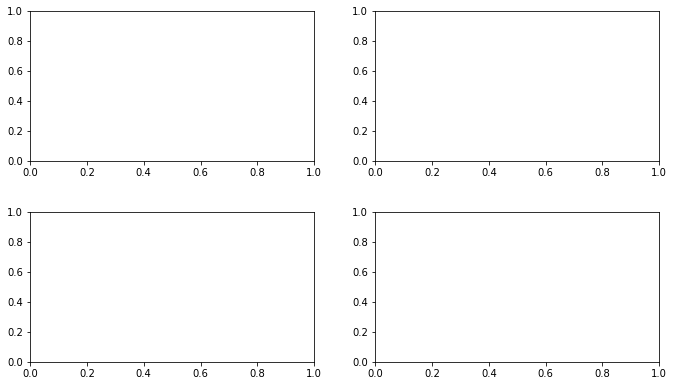

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -688     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 303      |
|    time_elapsed    | 13       |
|    total_timesteps | 4000     |
---------------------------------


KeyboardInterrupt: 

In [13]:
# train an agent
with ProgressBarManager(
    rl_params["total_timesteps"]
) as progress_bar_callback:
    model.learn(
        total_timesteps=rl_params["total_timesteps"],
        callback=[progress_bar_callback, eval_callback, event_plotting_callback, print_callback],
    )

# train an agent with specific steps
# continue_training_steps = 400000
# with ProgressBarManager(
#     continue_training_steps
# ) as progress_bar_callback:
#     model.learn(
#         total_timesteps=continue_training_steps,
#         callback=[progress_bar_callback, eval_callback, event_plotting_callback, print_callback],
#     )

In [ ]:
batch_size = 512
if model.replay_buffer.full:
    episode_indices = (
        np.random.randint(1, model.replay_buffer.n_episodes_stored, batch_size) + model.replay_buffer.pos
    ) % model.replay_buffer.n_episodes_stored
else:
    episode_indices = np.random.randint(0, model.replay_buffer.n_episodes_stored, batch_size)
# A subset of the transitions will be relabeled using HER algorithm
her_indices = np.arange(batch_size)[: int(model.replay_buffer.her_ratio * batch_size)]
 
ep_lengths = model.replay_buffer.episode_lengths[episode_indices]

her_indices = her_indices[ep_lengths[her_indices] > 1]
ep_lengths[her_indices] -= 1

transitions_indices = np.random.randint(ep_lengths)

# get selected transitions
transitions = {key:  model.replay_buffer._buffer[key][episode_indices, transitions_indices].copy() for key in  model.replay_buffer._buffer.keys()}

# sample new desired goals and relabel the transitions
new_goals =  model.replay_buffer.sample_goals(episode_indices, her_indices, transitions_indices)
transitions["desired_goal"][her_indices] = new_goals

transitions["info"] = np.array(
    [
        model.replay_buffer.info_buffer[episode_idx][transition_idx]
        for episode_idx, transition_idx in zip(episode_indices, transitions_indices)
    ]
)

transitions["reward"][her_indices, 0] = model.replay_buffer.env.env_method(
                "compute_reward",
                # the new state depends on the previous state and action
                # s_{t+1} = f(s_t, a_t)
                # so the next_achieved_goal depends also on the previous state and action
                # because we are in a GoalEnv:
                # r_t = reward(s_t, a_t) = reward(next_achieved_goal, desired_goal)
                # therefore we have to use "next_achieved_goal" and not "achieved_goal"
                transitions["next_achieved_goal"][her_indices, 0],
                # here we use the new desired goal
                transitions["desired_goal"][her_indices, 0],
                transitions["info"][her_indices, 0],
            )


In [ ]:
reward = model.replay_buffer.env.env_method(
                "compute_reward",
                # the new state depends on the previous state and action
                # s_{t+1} = f(s_t, a_t)
                # so the next_achieved_goal depends also on the previous state and action
                # because we are in a GoalEnv:
                # r_t = reward(s_t, a_t) = reward(next_achieved_goal, desired_goal)
                # therefore we have to use "next_achieved_goal" and not "achieved_goal"
                transitions["next_achieved_goal"][her_indices, 0],
                # here we use the new desired goal
                transitions["desired_goal"][her_indices, 0],
                transitions["info"][her_indices, 0],
            )
transitions["next_achieved_goal"][her_indices, 0].shape

(409, 8)

In [ ]:
(transitions["next_achieved_goal"][her_indices, 0][:,4:6] * transitions["desired_goal"][her_indices, 0][:,4:6]).shape

(409, 2)

In [ ]:
def get_pos_dist(pos_1, pos_2):
    """
    Compute the L2 distance
    """
    dist = np.linalg.norm(pos_1 - pos_2, axis=1)
    return dist

def get_orn_dist(orn_1, orn_2):
        """
        Compute the orn distance.
        """
        inner_product = np.sum(orn_1 * orn_2, axis=1)
        dist = np.arccos(
            np.clip(
                (2 * (inner_product ** 2)) - 1,
                -1, 1)
        )
        return dist

# get_pos_dist(transitions["next_achieved_goal"][her_indices, 0][:,4:6], transitions["desired_goal"][her_indices, 0][:,4:6]).shape
get_orn_dist(transitions["next_achieved_goal"][her_indices, 0][:,4:6], transitions["desired_goal"][her_indices, 0][:,4:6]).shape

(409,)

In [ ]:
pos = env.envs[0].cur_obj_pos_worldframe
goal_pos = env.envs[0].goal_pos_worldframe
orn = env.envs[0].cur_obj_orn_worldframe
goal_orn = env.envs[0].goal_orn_worldframe
print(get_pos_dist(np.expand_dims(pos,0), np.expand_dims(goal_pos,0)))
print(env.envs[0].get_pos_dist(np.expand_dims(pos,0), np.expand_dims(goal_pos,0)))

# print(get_orn_dist(orn, goal_orn))
print(get_orn_dist(np.expand_dims(orn,0), np.expand_dims(goal_orn,0)))
print(get_orn_dist(np.array([orn]), np.array([goal_orn])))

# print(env.envs[0].get_orn_dist(np.expand_dims(orn,0), np.expand_dims(goal_orn,0)))

orn_batch = np.array([orn, orn])
goal_orn_batch = np.array([goal_orn, goal_orn])
print(get_orn_dist(orn_batch, goal_orn_batch))

[0.120968]
0.120968062328904
[2.586713]
[2.586713]
[2.586713 2.586713]


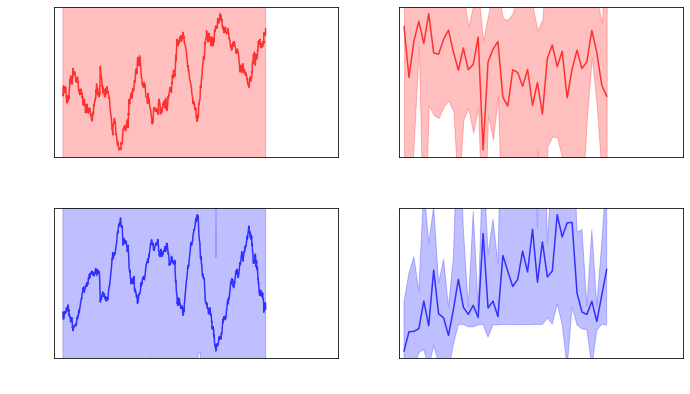

In [ ]:
plt.ion()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig.tight_layout(pad=3.0)
for (m,n), subplot in np.ndenumerate(axs):
    subplot.xaxis.label.set_color('white')
    subplot.yaxis.label.set_color('white')
    subplot.tick_params(axis='x', colors='white')
    subplot.tick_params(axis='y', colors='white')


for ax in axs.flat:
    ax.clear()

plot_train_and_eval(save_dir, fig=fig, axs=axs, show_plot=False)
for ax in axs.flat:
    ax.relim()
    ax.set_xlim([0, rl_params["total_timesteps"]/2  * 1.15])
    ax.autoscale_view(True, True, True)

fig.canvas.draw()

In [ ]:
# save the final model after training
model.save(os.path.join(save_dir, "trained_models", "final_model"))
env.close()
eval_env.close()


Destroy EGL OpenGL window.
Destroy EGL OpenGL window.


In [ ]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter

results = load_results(save_dir)

timesteps, _ = ts2xy(results, "timesteps")
rewards = np.array(results["r"])
ep_lengths = np.array(results["l"])

In [ ]:
x_r, mean_rew = results_plotter.window_func(timesteps, rewards, 10, np.mean)

In [ ]:
eval_data = np.load(os.path.join(save_dir, "trained_models", "evaluations.npz"))
timesteps = eval_data["timesteps"]
rewards = eval_data["results"]
ep_lengths = eval_data["ep_lengths"]

In [ ]:
rewards

array([[-2455.998017, -2241.137662, -3681.963024, -26.111338,
        -2393.836135, -3188.915765, -2209.701687, -2098.672077,
        -2379.963008, -3362.960308],
       [-2207.375246, -1971.588480, -794.213671, -90.212560,
        -3384.742599, -2081.137504, -32.464114, -3696.543274,
        -2264.602996, -2107.164707]])

In [ ]:
from tactile_gym.utils.general_utils import load_json_obj

rl_params = load_json_obj(os.path.join(save_dir, "rl_params"))
algo_params = load_json_obj(os.path.join(save_dir, "algo_params"))

# create the evaluation env
rl_params["env_modes"]['eval_mode'] = True
rl_params["env_modes"]['eval_num'] = rl_params["n_eval_episodes"]
eval_env = make_eval_env(
    rl_params["env_name"],
    rl_params,
    show_gui=show_gui,
    show_tactile=show_tactile,
)

NameError: name 'save_dir' is not defined

In [ ]:
# run final evaluation over 20 episodes and save a vid
# save_dir = os.path.join(
#     "saved_models/", rl_params["env_name"], algo_name, "s{}_{}".format(rl_params["seed"], rl_params["env_modes"]["observation_mode"])
# )

# Local machine
save_dir = r"/home/qt21590/Documents/Projects/tactile_gym_mbrl/tactile_gym_dev/tactile_gym/sb3_helpers/saved_models/object_push-v0/sac/s1_tactile_pose_updated"
# Compute machine
# save_dir = r"/home/qt21590/Documents/Projects/tactile_gym_mbrl/tactile_gym_dev/models/push_ppo_oracle_reduced_terminate_early"

final_evaluation(
    saved_model_dir=save_dir,
    n_eval_episodes=10,
    seed=None,
    deterministic=True,
    show_gui=False,
    show_tactile=False,
    render=True,
    save_vid=True,
    take_snapshot=False
)


argv[0]=
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 495.29.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 495.29.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
ven = NVIDIA Corporation
ven = NVIDIA Corporation
Avg Ep Rew: -139.53003694705998, Avg Ep Len: 397.6
Destroy EGL OpenGL window.


([-275.7985007815448,
  -456.1032345172626,
  -147.35427660746296,
  -243.41405936709364,
  -58.47860624914505,
  -101.45467633861543,
  -27.554614935606057,
  -8.636748185189681,
  -15.296969168070913,
  -61.208683320608486],
 [437, 586, 321, 497, 302, 388, 370, 308, 341, 426])

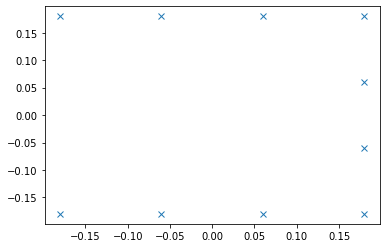

In [ ]:
goals = np.array([[-0.180000,-0.180000],
                    [-0.180000, 0.180000],
                    [-0.060000, -0.180000],
                    [-0.060000, 0.180000],
                    [0.060000, -0.180000],
                    [0.060000, 0.180000],
                    [0.180000, -0.180000],
                    [0.180000, -0.060000],
                    [0.180000, 0.060000],
                    [0.180000, 0.180000]])


plt.plot(goals[:, 0], goals[:, 1], 'x')